In [1]:
import numpy as np
import pandas as pd
import implicit
import matplotlib.pyplot as plt
import matplotlib
from scipy.sparse import csr_matrix
from scipy.linalg import svd
from scipy.sparse.linalg import eigsh
from scipy.stats import spearmanr

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA 
from sklearn.metrics import silhouette_score

import pickle
import heapq
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities

from tqdm import tqdm 
import time

from functools import partial
import multiprocessing as mp

import loaders.lastfm
from loaders.movielens import movielens
import utils

In [2]:
colors = ["#1b9e77",
          "#d95f02",
          "#7570b3",
          "#e7298a",
          "#66a61e",
          "#e6ab02",
          "#a6761d",
          "#666666" 
         ]

# Load dataset

In [11]:
lastfm_obj = loaders.lastfm.lastfm(data_dir = "data/lastfm/")
R = lastfm_obj.filter(min_users = 0, min_ratings = 49)
R[R != 0] = 1
R = R[:, np.argsort(-np.sum(R, axis = 0))]
print("Minimum number of ratings by user: ", np.mean(np.sum(R, axis = 1)))

R_train, R_val, R_test = utils.split_data(R)
print("Training Interactions: {},\nVal Interactions: {},\nTest Interactions: {}".format(
    np.sum(R_train), np.sum(R_val), np.sum(R_test)
))

high_start, medium_start, low_start = utils.get_popularity_splits(R)
print("Num High Popularity: {}\nNum Medium Popularity: {}\nNum Low Popularity: {}".format(
    medium_start, low_start - medium_start, R.shape[1] - low_start
))
#U, S, Vh = svd(R, full_matrices=False)

(1829, 17632)
Minimum number of ratings by user:  50.0
Training Interactions: 64015.0,
Val Interactions: 9145.0,
Test Interactions: 18290.0
Num High Popularity: 198
Num Medium Popularity: 1212
Num Low Popularity: 16222


In [13]:
movielens_obj = movielens(top_k_users = 0, top_k_items = 0, binary = True)
R = movielens_obj.get_X()
R[R != 0] = 1
R = R[:, np.argsort(-np.sum(R, axis = 0))]
print("Minimum number of ratings by user: ", np.min(np.sum(R != 0, axis = 1)))

R_train, R_val, R_test = utils.split_data(R)
print("Training Interactions: {},\nVal Interactions: {},\nTest Interactions: {}".format(
    np.sum(R_train), np.sum(R_val), np.sum(R_test)
))

high_start, medium_start, low_start = utils.get_popularity_splits(R)
print("Num High Popularity: {}\nNum Medium Popularity: {}\nNum Low Popularity: {}".format(
    medium_start, low_start - medium_start, R.shape[1] - low_start
))

# plt.hist(np.sum(R != 0, axis = 1), bins = 100)
#U, S, Vh = svd(R, full_matrices=False)

(6040, 3706)
Minimum number of ratings by user:  20
Training Interactions: 705170.0,
Val Interactions: 97383.0,
Test Interactions: 197656.0
Num High Popularity: 236
Num Medium Popularity: 541
Num Low Popularity: 2929


In [5]:
R.shape

(6041, 3707)

In [ ]:
def get_lastfm():
    lastfm_obj = lastfm.lastfm(data_dir = "data/lastfm/")
    P = lastfm_obj.filter(min_users = 5, min_ratings = 0)

    P = np.linalg.inv(np.diag(np.sum(P, axis=1))) @ P
    assert np.allclose(np.sum(P, axis=1), np.ones(len(P)))
    return P, lastfm_obj

In [ ]:
def get_movielens():
    movielens_obj = movielens(top_k_users = 2000, top_k_items = 1000, binary = False)
    idx_to_genres = movielens_obj.get_genres()
    X = movielens_obj.get_X()
    assert X.shape[1] == len(idx_to_genres)

    genres_to_idx = {}
    for idx in idx_to_genres:
        for genre in idx_to_genres[idx]:
            if genre not in genres_to_idx:
                genres_to_idx[genre] = []
            genres_to_idx[genre].append(idx)

    column_sample = []
    for genre in genres_to_idx:
        idxs = np.array(genres_to_idx[genre])
        top_idx = np.argsort(np.sum(X[:, idxs] != 0, axis = 0))[-30:]
        new_column_sample = column_sample.copy()
        for idx in idxs[top_idx]:
            if idx not in column_sample:
                new_column_sample.append(idx)
        column_sample = new_column_sample

    X = X[:, column_sample]

    X_top_movies = np.zeros(X.shape)
    for i in range(len(X)):
        top_movie_idxs = np.argsort(X[i])[-30:]
        X_top_movies[i, top_movie_idxs] = X[i, top_movie_idxs]
    
    X_binary = np.zeros(X.shape)
    X_binary[X_top_movies == 1] = -2
    X_binary[X_top_movies == 2] = -1
    X_binary[X_top_movies == 3] = 1
    X_binary[X_top_movies == 4] = 2
    X_binary[X_top_movies == 5] = 3

    return X_binary / 100

In [21]:
# PARAMETERS
# Mine which artists see the largest improvement at each interval
P, lastfm_obj = get_lastfm()

# Version 1
# P[P > 0] = 1 

# Version 2
P[P > 0] = 1
P_binary = P.copy()
P = P @ np.linalg.inv(np.diag(np.sqrt(np.sum(P, axis = 0))))

d = P.shape[1]
rs = np.arange(1, d)

(1880, 2417)


## Generate Teaser

100%|██████████| 300/300 [00:10<00:00, 27.34it/s]


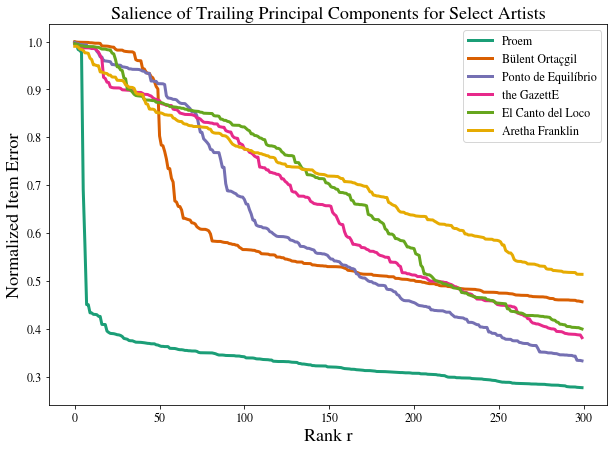

In [15]:
SMALL_SIZE = 12
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

interval_start_idxs = [1, 50, 100, 150, 200, 250]
interval_gap = 10

U, S, Vh = svd(P, full_matrices=False)
# assert np.allclose(P, U @ np.diag(S) @ Vh)

plt.rc('font', size=SMALL_SIZE, family = "Nimbus Roman")          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

ncols = len(interval_start_idxs)
fig, ax = plt.subplots(figsize = (10, 7))

# err = []
# for r in np.arange(0, P.shape[1]):
#     P_pred = P @ Vh[:r].T @ Vh[:r]
# #     P_pred = P @  proj_matrices_max_pred[r]
#     err.append(np.linalg.norm(P - P_pred)**2)

# ax.plot(err / np.linalg.norm(P)**2, label = "Global", linewidth = 3, c = colors[-1], linestyle = "--")

for idx, interval_start_idx in enumerate(interval_start_idxs):
    artist_idx = -1
    max_improvement = -1
    
    start_idx = interval_start_idx
    end_idx = interval_start_idx + interval_gap
    
    proj_mtx_start = Vh[:start_idx].T @ Vh[:start_idx]
    proj_mtx_end = Vh[:end_idx].T @ Vh[:end_idx]
#     proj_mtx_start =  proj_matrices_max_pred[start_idx]
#     proj_mtx_end = proj_matrices_max_pred[end_idx]
    
    P_err_start = P - P @ proj_mtx_start
    P_err_end = P - P @ proj_mtx_end
    
    for j in range(P.shape[1]):
        improvement_gap = (np.linalg.norm(P_err_start[:, j])**2 - np.linalg.norm(P_err_end[:, j])**2)\
                            / np.linalg.norm(P[:, j])**2
        if improvement_gap > max_improvement:
            max_improvement = improvement_gap
            artist_idx = j
    
    err = []
    P_pred = np.zeros(P.shape)
    for r in tqdm(np.arange(0, 300)):
        P_pred += np.outer(P @ Vh[r], Vh[r])
#         P_pred = P @ proj_matrices_max_pred[r]
        err.append(np.linalg.norm(P[:, artist_idx] - P_pred[:, artist_idx])**2)
        
    ax.plot(err / np.linalg.norm(P[:, artist_idx])**2,
           label = lastfm_obj.convert_artist_idx_to_name(artist_idx),
           c = colors[idx],
           linewidth = 3)
    
ax.set_xlabel("Rank r")
ax.set_ylabel("Normalized Item Error")
ax.set_title("Salience of Trailing Principal Components for Select Artists")
ax.legend()
# plt.savefig("figs/salience_of_trailing_components.pdf", bbox_inches = "tight")

In [ ]:
# USE FOR FIGURE 1 TEASER AND FIGURE 2A
P = get_lastfm()
with open("pickles/max_pred_lastfm_all_cosine.pickle", "rb") as pickleFile:
    description, train_idxs, proj_matrices_max_pred = pickle.load(pickleFile)

# UNCOMMENT TO GENERATE RESULTS FOR FIGURE 2B
# P = get_movielens()
# with open("pickles/max_pred_movielens_train_cosine.pickle", "rb") as pickleFile:
#     description, train_idxs, proj_matrices_max_pred = pickle.load(pickleFile)


'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


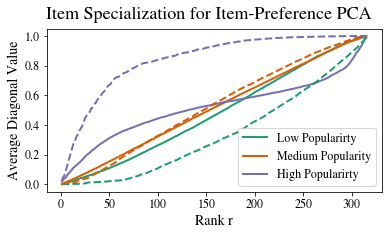

In [17]:
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels

U, S, Vh = np.linalg.svd(P, full_matrices = False)
d = P.shape[1] # should equal len(S)

low_artist_filter = np.sum(P > 0, axis = 0) < 50
med_artist_filter = (np.sum(P > 0, axis = 0) >= 50) & (np.sum(P > 0, axis = 0) <= 150)
high_artist_filter = np.sum(P > 0, axis = 0) > 150
assert np.all((low_artist_filter | med_artist_filter) | high_artist_filter)
assert np.sum(low_artist_filter) + np.sum(med_artist_filter) + np.sum(high_artist_filter) == d


fig_diag, ax_diag = plt.subplots(figsize = (6,3))
fig_diag.suptitle("Item Specialization for Item-Preference PCA")


diagonals = np.zeros((len(S) - 1, len(S)))
for idx, r in enumerate(range(1, len(S))):
#     proj_mtx = Vh[:r].T @ Vh[:r]
    proj_mtx = proj_matrices_max_pred[r]
    diagonals[idx] = np.diagonal(proj_mtx)
ax_diag.plot(range(1, len(S)), np.mean(diagonals[:, low_artist_filter], axis = 1), label = "Low Popularirty", c = colors[0], linewidth = 2)
ax_diag.plot(range(1, len(S)), np.mean(diagonals[:, med_artist_filter], axis = 1), label = "Medium Popularity", c = colors[1], linewidth = 2)
ax_diag.plot(range(1, len(S)), np.mean(diagonals[:, high_artist_filter], axis = 1), label = "High Popularirty", c = colors[2], linewidth = 2)

diagonals = np.zeros((len(S) - 1, len(S)))
for idx, r in enumerate(range(1, len(S))):
    proj_mtx = Vh[:r].T @ Vh[:r]
    diagonals[idx] = np.diagonal(proj_mtx)
ax_diag.plot(range(1, len(S)), np.mean(diagonals[:, low_artist_filter], axis = 1), linestyle = "--", c = colors[0], linewidth = 2)
ax_diag.plot(range(1, len(S)), np.mean(diagonals[:, med_artist_filter], axis = 1), linestyle = "--", c = colors[1], linewidth = 2)
ax_diag.plot(range(1, len(S)), np.mean(diagonals[:, high_artist_filter], axis = 1), linestyle = "--", c = colors[2], linewidth = 2)


#DIAGONALS
#ax_diag.set_title(alg_name)
ax_diag.set_xlabel("Rank r")
ax_diag.set_ylabel("Average Diagonal Value")

ax_diag.legend()

fig_diag.savefig("figs/lastfm_reliance_on_diagonal_max_pred.pdf", bbox_inches = "tight")

229.5879917184265
278.3743536711479


'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


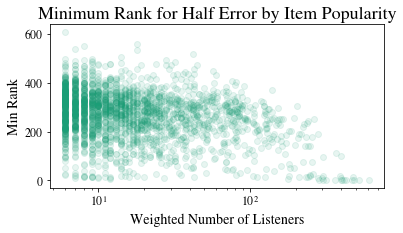

In [26]:
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
# plt.rc('font', fontsize=18)    # fontsize of the x and y labels

fig, ax = plt.subplots(figsize = (6, 3))
ax.set_xscale("log")
ax.set_xlabel("Weighted Number of Listeners")
ax.set_ylabel("Min Rank")
ax.set_title("Minimum Rank for Half Error by Item Popularity")

U, S, Vh = np.linalg.svd(P, full_matrices = False)
# err = P - P_pred
# err_normalized = np.linalg.norm(err, axis = 0) / np.linalg.norm(P, axis = 0)
# min_ranks_for_half_accuracy = np.zeros(P.shape[1])
# P_pred = np.zeros(P.shape)
# max_r = min(P.shape)
# for r in tqdm(range(max_r)):
#     P_pred += np.outer(P @ Vh[r], Vh[r])
#     for j in range(P.shape[1]):
#         norm_err = np.linalg.norm(P[:, j] - P_pred[:, j])**2 / np.linalg.norm(P[:, j])**2
#         if min_ranks_for_half_accuracy[j] == 0 and norm_err < 0.5:
#             min_ranks_for_half_accuracy[j] = r
            
popularities = np.sum(P_binary, axis = 0)
ax.scatter(x = popularities, y = min_ranks_for_half_accuracy, c = colors[0], alpha = 0.1, label = "Vanilla")

# P_pred = P @ proj_matrices_max_pred[r]
# err = P - P_pred
# err_normalized = np.linalg.norm(err, axis = 0) / np.linalg.norm(P, axis = 0)
# ax.scatter(x = popularities, y = err_normalized, c = colors[1], alpha = 0.4, label = "Max Prediction")

#ax.set_yscale("log")
# ax.legend()

num_head = int(0.2 * P.shape[1])
top_popularities_idx = np.argsort(popularities)
print(np.mean(min_ranks_for_half_accuracy[top_popularities_idx[-num_head:]]))
print(np.mean(min_ranks_for_half_accuracy[top_popularities_idx[:-num_head]]))

fig.savefig("figs/top_artist_specialization.pdf", bbox_inches = "tight")


In [24]:
min_ranks_for_half_accuracy

array([ 12., 274., 251., ..., 253., 239., 312.])